## Logistic Regression Tutorial 

# 1. Importing Packages 


This tutorial requires primarily all the basic functions needed by a mathematical alogrithm. These include the NumPy library, Matplotlib, and Pandas libraries. Furthemore, the logistic regression tools require the Scikit-Learn library. 

- Scikit Learn is one of the most powerful Python Machine Learning Libraries containing important functions such as interpolation, regression, classification matrix etc 
- Igor function is used for importing ibw file (AFM Curve data file) format into python dictionary 
- Scipy.inerpolate is an interpolation function within the scikit-learn library  



In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
#import math 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, confusion_matrix
import scipy.interpolate as interp
import igor.binarywave as ibw           # https://pypi.org/project/igor/
import glob

# 2. Reading AFM Dynamic Approach Curve Files 

- AFM Dynamic Curves are a set of Amplitude (A) vs Surface Displacement (Z) curves. The AFM tip is excited using a periodic signal which has an amplitude and a phase. 
- We need to import the different classes of data into the code using the glob.glob function. 
- We define a dictionary 'filelist' containing all our input data. 


In [2]:
filelist_onsurface = glob.glob('Data\\On_Surface\*.ibw')  
filelist_offsurface = glob.glob('Data\\Off_Surface\*.ibw')  
filelist_unlabeled = glob.glob('Data\\Unlabeled\*.ibw')


filelist = [filelist_onsurface, filelist_offsurface, filelist_unlabeled]



# 3. Organizing Curves into Dictionary 

-A Dictionary is a python structure that stores objects referenced by keys, whee a key is a desciptior that returns a specfic object from the dictionary. 

-Keys are specified in dictionaries to reference specific file names. Here we create two keys: Key 1: whether file is On Surface or Off Surface file, Key 2: Specific file name. This section also creates a key in the dictionary in case one does not already exist. 

-All of this is done to navigate easily through the dictionary and be able to reference a specific object of the dictionary when required. 



In [3]:
data = {}                                           # Master dictionary 

for filetype in filelist:         
    for file in filetype: 
        indata = ibw.load(file)                     # Loads data from ibw file into indata 
        
        
        key1 = file.split('\\')[1]                  # key1 is On or Off surface state 
        key2 = file.split('\\')[2][0:-4]            # key2 is specific file name 
        
        try:                                        # Creates dictionary key if it does not exist 
            data[key1] 
        except: 
            data[key1] = {}            
        
        try: 
            data[key1][key2] 
        except: 
            data[key1][key2] = {}
            
                            
        
        for key in enumerate(indata['wave']['labels'][1][1:]):     
            data[key1][key2][str(key[1])[2:-1]] = indata['wave']['wData'][:,key[0]]         # Places amplitude, phase, and Z in data
            
        notedic = {}                                                                                
        for item in str(indata['wave']['note']).split('\\r'):
            try: 
                notedic[item.split(':')[0]] = item.split(':')[1]
            except: 
                #print("Warrning cannot parse note entry: " + item)
                pass
        
        data[key1][key2]['note'] = notedic                                                  # Place file meta data in data 


# 4. Visualizing Amplitude vs Z Curves and Phase vs Z Curves 

-Amplitude is the amplitude of the cantilever oscillation
-Phase is the phase of the cantilever oscillation relative to the peroidic signal used to excite the cantilever 
-Z is the surface displacement ( position of the surface)
-Helps us plot the input curves to better visualize the shape and patterns of the different classes of data ( On Surface, Off Surface, Unlabeled) 
-Note: There is no steep change in slope of AZ Curves for Off Surface plots i.e no contact whereas there is a sharp dip in AZ Curves of On Surface plots


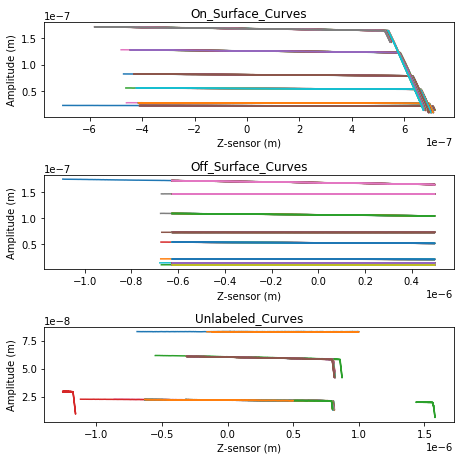

In [4]:
#plt.figure()            # Plots single curve 
#plt.plot(data['Off_Surface']['AZ_0101']['ZSnsr'],data['Off_Surface']['AZ_0101']['Amp'])    

count = 1 
plt.figure(figsize=(6.5,6.5))            # Plots all curves 
for key1 in data.keys(): 
    plt.subplot(3,1,count)
    plt.title(key1 + "_Curves")
    plt.xlabel('Z-sensor (m)')
    plt.ylabel('Amplitude (m)')
    for key2 in data[key1].keys():
        plt.plot(data[key1][key2]['ZSnsr'],data[key1][key2]['Amp']) 
    count = count + 1

plt.tight_layout()

#Add axis titles 

# 5. Training Logistic Regression Model 

- We use the Logistic Regression Function in the Scikit Learn Library to train the model. 
- There are two components to training a mode: x_train and y_train. 
- Our choice of descriptors for this code is the Amplitudes. 
- We regularize the Amplitudes using the concept of interpolation. It is important to regularize the number of desctiptors in each curve as each curve has a different number of points and a logistic model can only take one constant number of desciptors into account for prediction. 

In [5]:
model = LogisticRegression(solver='liblinear', random_state=0)

x_train = []
y_train = []

Zpts = 50 
for key1 in list(data.keys())[0:2]: 
    for key2 in data[key1].keys(): 
        interp_func = interp.interp1d(data[key1][key2]['ZSnsr'] ,data[key1][key2]['Amp']*1e9 )              # Creates interpolation function
        Zmin = np.min(data[key1][key2]['ZSnsr'])                        
        Zmax = np.max(data[key1][key2]['ZSnsr'])
        Zintp = np.linspace(Zmin,Zmax,Zpts)                                                                 # Creates interpolation points
        Ampintp = interp_func(Zintp)                                                                        # Does interpolation 
        if True in np.isnan(Ampintp): 
            print('Warning: Nan on interp:' + key1 + ', ' + key2)        
        else: 
            x_train.append(Ampintp)                                                                         # Builds xtrain 
            if key1 == 'On_Surface':                                                                        # Builds ytrain 
                y_train.append(1)
            else: 
                y_train.append(0)

                
output = model.fit(x_train, y_train)            

   

# 6. Testing logistical regression model 

- Here we test the trained model over a specific index curve ( for example: 55)  
- We interpolate the amplitudes using the scikit.interpolate function over the AZ curves for regularization. 
- Both the prediction and the true value for the AZ curve are printed. 


In [6]:
#test_index = 55                                                                                             # Test index 
#pred_data = model.predict([x_train[test_index]])                                                            # Does test 
#print('Prediction: ', pred_data[0], ', Truth: ', y_train[test_index])

print('0 = Off Surface,  1 = On Surface')

predictions = {}

key1 = 'Unlabeled'
for key2 in data[key1].keys():
    interp_func = interp.interp1d(data[key1][key2]['ZSnsr'] ,data[key1][key2]['Amp']*1e9 )              # Creates interpolation function
    Zmin = np.min(data[key1][key2]['ZSnsr'])                        
    Zmax = np.max(data[key1][key2]['ZSnsr'])
    Zintp = np.linspace(Zmin,Zmax,Zpts)                                                                 # Creates interpolation points
    Ampintp = interp_func(Zintp) 
    
    pred_data = model.predict([Ampintp])                                                                 # Tests unlabeled data 
    print(key2, '  Prediction : ', pred_data[0])
    predictions[key2] = pred_data[0]

0 = Off Surface,  1 = On Surface
AZ_0000   Prediction :  0
AZ_0001   Prediction :  0
AZ_0002   Prediction :  1
AZ_0003   Prediction :  1
AZ_0004   Prediction :  1
AZ_0005   Prediction :  1
AZ_0006   Prediction :  1
AZ_0007   Prediction :  1
AZ_0008   Prediction :  1
AZ_0009   Prediction :  1
AZ_0010   Prediction :  1
AZ_0011   Prediction :  1
AZ_0012   Prediction :  1
AZ_0013   Prediction :  1
AZ_0014   Prediction :  1
AZ_0015   Prediction :  1
AZ_0016   Prediction :  1
AZ_0017   Prediction :  1
AZ_0018   Prediction :  1
AZ_0019   Prediction :  1
AZ_0020   Prediction :  1
AZ_0021   Prediction :  1
AZ_0022   Prediction :  1
AZ_0023   Prediction :  1
AZ_0024   Prediction :  1
AZ_0025   Prediction :  1
AZ_0026   Prediction :  1
AZ_0027   Prediction :  1
AZ_0028   Prediction :  1
AZ_0029   Prediction :  1
AZ_0030   Prediction :  1
AZ_0031   Prediction :  1
AZ_0032   Prediction :  1
AZ_0033   Prediction :  1
AZ_0034   Prediction :  1
AZ_0035   Prediction :  1
AZ_0036   Prediction :  1
AZ_00

# 7. Results Visualization 

- Plots a specific AZ Curve we apply the algorithm on. 
- This makes it much easier for the user to understand the application of the code and easily verify whether the result is right or not. 

-In the example below, the prediction is 0 (off_surface) and the truth is also 0 (off_surface curve). Hence the algorithm is working accurately. 

(8e-08, 8.5e-08)

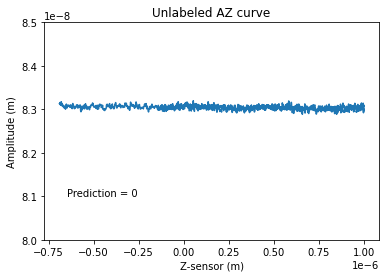

In [7]:
plt.figure()            # Plots single curve 
plt.plot(data['Unlabeled']['AZ_0000']['ZSnsr'], data['Unlabeled']['AZ_0000']['Amp'])
plt.title('Unlabeled AZ curve')
plt.xlabel('Z-sensor (m)')
plt.ylabel('Amplitude (m)')
plt.text(-.65e-6,8.1e-8,'Prediction = ' + str(predictions['AZ_0000']))
plt.ylim([8e-8, 8.5e-8])

# 8. Future Improvements

This code can be made more accurate through two main methods. 
1. The desciptors can be changed ( Currently using amplitudes) such that they offer a more accurate prediction of the given data 
2. The method of regularizing ( currently using interpolation) can be altered to fit the points of each AZ curve better which would make the predictions more accurate. 

Any further inputs on how to further improve this code are welcome. Please contact the Authors at the emails mentioned in the header. 

We hope this tutorial was helpful

Thank you!